<a href="https://colab.research.google.com/github/MASHAR27/BCHACKS2024/blob/main/BCHacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np

In [2]:
!pip install wandb
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
class Music(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.pos = torch.nn.Embedding(200, 512).to(device)
    self.projection = torch.nn.Linear(3, 512).to(device)
    self.trans = torch.nn.TransformerEncoder(torch.nn.TransformerEncoderLayer(512, 8, batch_first=True), 8).to(device)
    self.output = torch.nn.Linear(512, 3).to(device)
  def forward(self, x):
    pos = self.pos(torch.arange(0,200).to(device))
    feature = self.projection(x) + pos
    feature = self.trans(feature, mask=torch.nn.Transformer.generate_square_subsequent_mask(200), is_causal=True)
    return self.output(feature)
model = Music()
model(torch.rand(1,200,3).to(device)).shape

torch.Size([1, 200, 3])

In [4]:
with open("transformer.csv","r") as f:
  data=f.read().split("\n")

new_data=[]
for i in data:
  if len(i.split(","))>=200:
    new_data.append([[int(i) for i in j.split(" ")] for j in i.split(",")[:200]])
new_data = np.array(new_data)

In [5]:
new_data.shape

(30071, 200, 3)

In [6]:
m = new_data.mean()
std = new_data.std()

In [7]:
m,std

(57.50019592519925, 527.9997419340993)

In [8]:
new_data = (new_data)/std

(array([0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 4.117580e+06, 1.016909e+06, 3.475720e+05,
        2.512640e+05, 2.647050e+05, 1.937430e+05, 2.812060e+05,
        6.933050e+05, 1.137166e+06, 5.720870e+05, 5.457100e+05,
        1.003717e+06, 1.061523e+06, 1.58

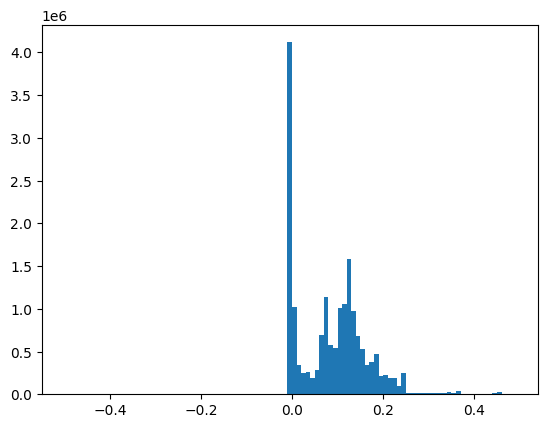

In [9]:
import pylab
pylab.hist((new_data).flatten(), bins=np.arange(-0.5,0.5,0.01))

In [10]:
BATCH_SIZE = 16

In [11]:
import random
def getdata():
  data = random.choices(new_data, k=BATCH_SIZE)
  data = np.array(data)
  return np.concatenate((np.zeros((BATCH_SIZE,1,3)),data[:,:-1,:]), axis=1), data

In [12]:
np.concatenate((np.zeros((10,1,3)),new_data[:10,:-1,:]), axis=1).shape


(10, 200, 3)

In [13]:
getdata()[0].shape,getdata()[1].shape

((16, 200, 3), (16, 200, 3))

In [14]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-6)
scheduler =  torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, len(new_data)//BATCH_SIZE*10)

In [15]:
import wandb
wandb.login()

wandb: Currently logged in as: wguo6358 (3dsmile). Use `wandb login --relogin` to force relogin


True

In [16]:
run = wandb.init(
    project="ba-hacks",
)

In [ ]:
model = model.to(device)
runing_loss = 0
count = 0
for epoch in range(30):
  for i in range(len(new_data)//BATCH_SIZE):
    x, y = getdata()
    x, y = torch.tensor(x).to(device).to(torch.float32), torch.tensor(y).to(device).to(torch.float32)
    output = model(x)
    loss = loss_fn(output, y)
    loss.backward()
    runing_loss += loss.item()
    count += 1
    if count==200:
      wandb.log({"loss":runing_loss/200})
      runing_loss = 0
      count = 0
    optimizer.step()
    scheduler.step()